# Préparation des données

In [2]:
import pandas as pd

df = pd.read_csv("synthetic.csv")

##### Q1
print("Nombre d'attributs des données :", df.columns.size - 1)

##### Q2
print(
    "Nombre des classes différentes dans les instances :",
    df["Class"].value_counts().count(),
)

##### Q3
print(
    "Nombre d'instances pour chaque classe :\n",
    df["Class"].value_counts().sort_index(),
    sep="",
)

Nombre d'attributs des données : 14
Nombre des classes différentes dans les instances : 4
Nombre d'instances pour chaque classe :
Class
0    674
1    908
2    472
3    244
Name: count, dtype: int64


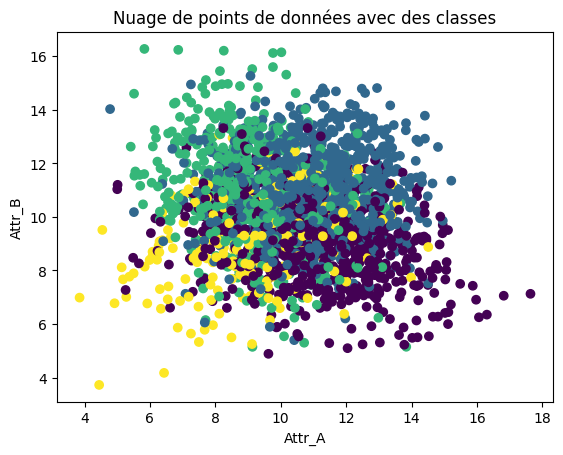

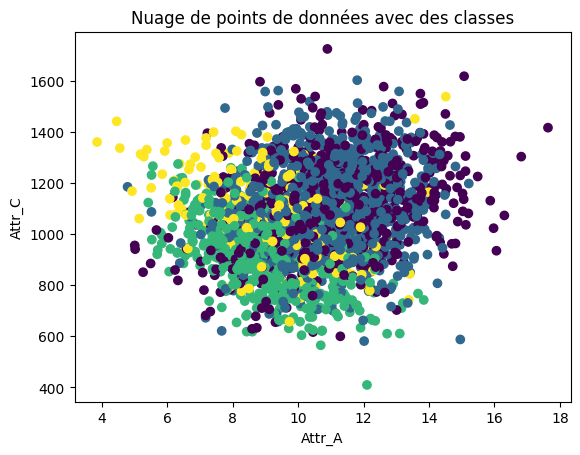

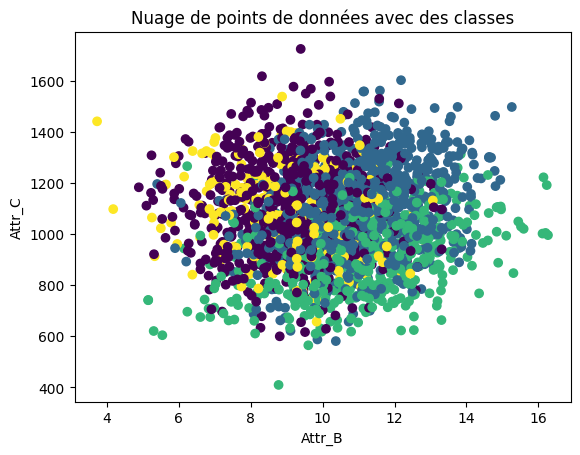

In [4]:
##### Q4
import matplotlib.pyplot as plt

# Visualisation 2 à 2 de quelques attributs avec les classes
plt.scatter(df["Attr_A"], df["Attr_B"], c=df["Class"])
plt.xlabel("Attr_A")
plt.ylabel("Attr_B")
plt.title("Nuage de points de données avec des classes")
plt.show()

plt.scatter(df["Attr_A"], df["Attr_C"], c=df["Class"])
plt.xlabel("Attr_A")
plt.ylabel("Attr_C")
plt.title("Nuage de points de données avec des classes")
plt.show()

plt.scatter(df["Attr_B"], df["Attr_C"], c=df["Class"])
plt.xlabel("Attr_B")
plt.ylabel("Attr_C")
plt.title("Nuage de points de données avec des classes")
plt.show()